In [13]:
import pandas as pd
import numpy as np

# Load the datasets
amr_data = pd.read_csv('final_AMR_data.csv')
gdp_data = pd.read_csv('gdp_data.csv')
health_expenditure = pd.read_csv('health_expenditure.csv')

# Display the first few rows and general information for each dataset
print("AMR Data Preview:")
print(amr_data.head())
print(amr_data.info())
print("\nGDP Data Preview:")
print(gdp_data.head())
print(gdp_data.info())
print("\nHealth Expenditure Data Preview:")
print(health_expenditure.head())
print(health_expenditure.info())


AMR Data Preview:
   Unnamed: 0               HealthTopic            Bacteria       Drug_Class   
0           0  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides  \
1           1  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides   
2           2  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides   
3           3  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides   
4           4  Antimicrobial resistance  Acinetobacter spp.  Aminoglycosides   

   Year geo RegionName  Completeness age_%  Completeness gender_%   
0  2012  AT    Austria                 NaN                    NaN  \
1  2012  BE    Belgium                 NaN                    NaN   
2  2012  BG   Bulgaria                 NaN                    NaN   
3  2012  CY     Cyprus                 NaN                    NaN   
4  2012  CZ    Czechia                 NaN                    NaN   

   I - 'susceptible, increased exposure' isolates _N   
0                             

In [14]:
# Merge the datasets on 'Year' and 'geo' keys
merged_data = pd.merge(amr_data, gdp_data, on=['Year', 'geo'], how='inner')
merged_data = pd.merge(merged_data, health_expenditure, on=['Year', 'geo'], how='inner')

# Data cleaning: Removing completely null columns and converting percentages
merged_data.drop(columns=['Completeness age_%', 'Completeness gender_%'], inplace=True)
merged_data['Penicillin non-wild-type isolates, percentage_%'] = pd.to_numeric(
    merged_data['Penicillin non-wild-type isolates, percentage_%'].str.replace('%', ''), errors='coerce')
merged_data['R - resistant isolates, percentage  _%'] = pd.to_numeric(
    merged_data['R - resistant isolates, percentage  _%'].str.replace('%', ''), errors='coerce')

In [15]:
# Handling missing values in numeric columns only
numeric_columns = merged_data.select_dtypes(include=[np.number]).columns
merged_data[numeric_columns] = merged_data[numeric_columns].fillna(merged_data[numeric_columns].median())

# Checking for any remaining NaN values
print("Remaining NaN values in dataset:", merged_data.isnull().sum().sum())




Remaining NaN values in dataset: 0


In [16]:
# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_data[numeric_columns])

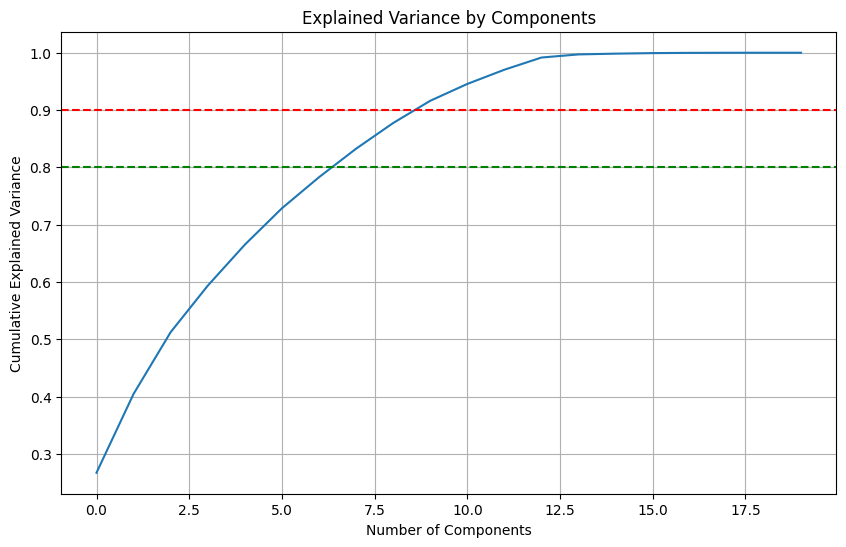

In [17]:
# Applying PCA to determine the number of components
pca = PCA()
pca.fit(X_scaled)

# Plotting the explained variance to determine the number of components to keep
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.axhline(y=0.8, color='g', linestyle='--')
plt.grid(True)
plt.show()

/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Optimal number of clusters based on silhouette score: 5


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


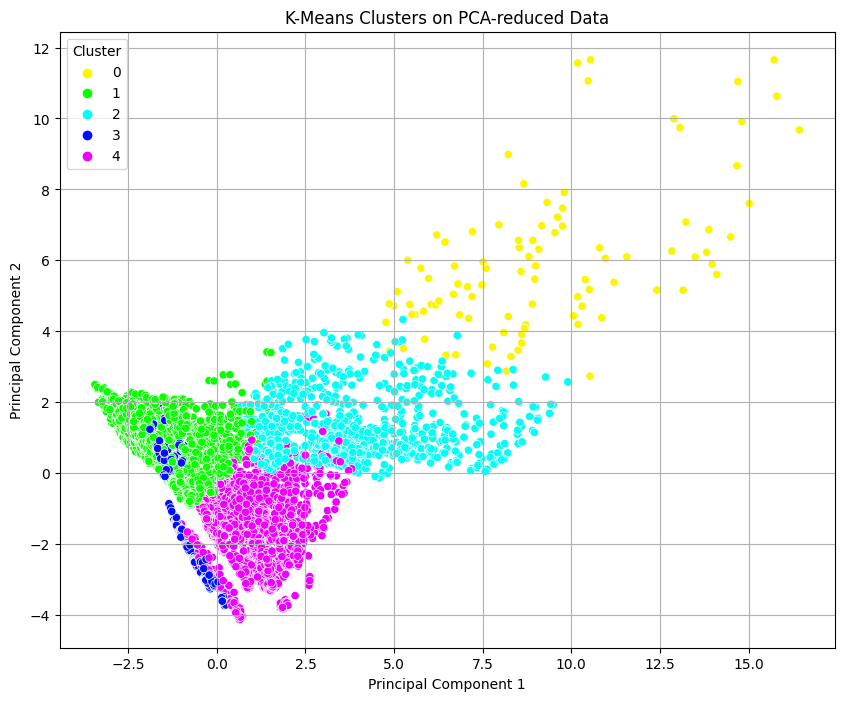

In [18]:
# Since we want to retain 90% of the variance, we will use 9 principal components for the PCA
pca_9 = PCA(n_components=9)
X_pca_9 = pca_9.fit_transform(X_scaled)

# Now, let's perform K-means clustering on this reduced data
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# We will use a range of cluster counts to find the best silhouette score
silhouette_scores = {}
for k in range(2, 11):  # Testing clusters from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca_9)
    silhouette_scores[k] = silhouette_score(X_pca_9, cluster_labels)

# Find the number of clusters with the highest silhouette score
optimal_cluster_count = max(silhouette_scores, key=silhouette_scores.get)
print("Optimal number of clusters based on silhouette score:", optimal_cluster_count)

# Perform K-means with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_cluster_count, random_state=42)
clusters = kmeans_optimal.fit_predict(X_pca_9)

# Add the cluster labels to our dataset
merged_data['Cluster'] = clusters

# Visualizing the clusters in the PCA reduced data
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca_9[:, 0], y=X_pca_9[:, 1], hue=clusters, palette=sns.color_palette("hsv", optimal_cluster_count))
plt.title('K-Means Clusters on PCA-reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [21]:
# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_data[numeric_columns])

# Applying PCA with the chosen number of components (e.g., 9 components for 90% variance)
pca = PCA(n_components=9)
X_pca = pca.fit_transform(X_scaled)

# Applying K-means clustering to the PCA-reduced data
from sklearn.cluster import KMeans

# Choose the number of clusters (e.g., 5) based on your previous analysis or domain knowledge
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_pca)

# Now you can compute the silhouette score
silhouette_avg = silhouette_score(X_pca, kmeans.labels_)
print("The average silhouette_score is :", silhouette_avg)



/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The average silhouette_score is : 0.2836541772448786
